In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import time
import datetime
import Pysolar #version 0.6 is compatible with Python 2.x

%matplotlib inline

In [2]:
#This is a list of all .txt files in the TXT files directory
CAISO_file_list = glob.glob('data/CAISO_data/CAISO_files/*.txt')

In [3]:
#Count of the length of file_list, and the expected length of the final DataFrame

print 'The length of the file list is : ', len(CAISO_file_list)
print 'The expected length of the DataFrame is: ' + str(24*len(CAISO_file_list))

The length of the file list is :  1865
The expected length of the DataFrame is: 44760


In [4]:
#This is the business loop.  It has to deal with .txt files with variable number of columns.  The end result are four
#dataxx_SW (xx = num cols) DataFrames with columns INDEX, WindTotal, and SolarPV.

#The format of the INDEX column is YYYYMMDDHH  --OR-- YYYYMMDDH, so a simple sort will put all data into 
#chronological order.
#WintTotal is the output of all wind powerplants for the indicated hour in MW

#initialization of DataFrames
data14 = pd.DataFrame([])
data16 = pd.DataFrame([])
data17 = pd.DataFrame([])
data18 = pd.DataFrame([])

#This loop takes each file in the CAISO_file_list and loads it into the appropriate DataFrame based on the number of
#columns in the raw data.
for f in CAISO_file_list:

    data_raw = pd.read_csv(f, sep = None, engine = 'python') #data_raw is rewritten on every loop
    
    #If-elif statement takes the data_raw input only once, this is important because the length of data_raw is
    #changed in the loop.  
    if data_raw.shape[1] == 14:
        data_raw.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV' ]
        data_raw = data_raw[1:25]
        data_raw['INDEX'] = f[28:36]+data_raw.Hour
        data14 = pd.concat([data14, data_raw], axis = 0)
        data14_SW = data14[['INDEX','WindTotal']]
        
    elif data_raw.shape[1] == 16:
        data_raw.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal' ]
        data_raw = data_raw[1:25]
        data_raw['INDEX'] = f[28:36]+data_raw.Hour
        data16 = pd.concat([data16, data_raw], axis = 0)
        data16_SW = data16[['INDEX','WindTotal']]
        
    elif data_raw.shape[1] == 17:
        data_raw.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','NONE','SolarThermal']
        data_raw = data_raw[1:25]
        data_raw['INDEX'] = f[28:36]+data_raw.Hour
        data17 = pd.concat([data17, data_raw], axis = 0)
        data17_SW = data17[['INDEX','WindTotal']]
        
    elif data_raw.shape[1] == 18:
        data_raw.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal','NONE','NONE' ]
        data_raw = data_raw[1:25]
        data_raw['INDEX'] = f[28:36]+data_raw.Hour
        data18 = pd.concat([data18, data_raw], axis = 0)
        data18_SW = data18[['INDEX','WindTotal']]
        

In [5]:
#Concatination of all dataxx_SW dataframes into one DataFrame, and reindex that dataframe 
#to sequential numbers
CAISO_Wind = pd.concat([data14_SW, data16_SW, data17_SW, data18_SW], axis = 0)

#Reindex data_SW so that each row in unique
CAISO_Wind.index = CAISO_Wind.INDEX

#Add leading zero to rows so that all INDEX entries have format YYYYMMDDHH
for i in range(0,CAISO_Wind.shape[0]):
    if len(CAISO_Wind.INDEX[i]) != 10:
        CAISO_Wind.INDEX[i] = CAISO_Wind.INDEX[i][:8] + '0' + CAISO_Wind.INDEX[i][8:]

#Sort data_SW by the value of the INDEX column, and reindex to have continuious row numbers
CAISO_Wind.index = CAISO_Wind.INDEX
CAISO_Wind = CAISO_Wind.sort('INDEX', ascending = True)

##Data Cleaning

In [6]:
#One particular daylight savings day has R appended on the end of the INDEX, this row is dropped.
if '201111062R' in CAISO_Wind.index:
    CAISO_Wind = CAISO_Wind.drop(CAISO_Wind.loc[CAISO_Wind['INDEX'] == '201111062R'].index[0])

In [7]:
#This transformation converts str to int via float.  Float type required because 201202281 was entered into CAISO
#raw data as float type.
CAISO_Wind.INDEX = CAISO_Wind.INDEX.astype(float)
CAISO_Wind.INDEX = CAISO_Wind.INDEX.astype(int)
CAISO_Wind.index = CAISO_Wind.INDEX.astype(int)

In [8]:
CAISO_Wind.head()

,INDEX,WindTotal
INDEX,,
2010042001,2010042001,632
2010042002,2010042002,632
2010042003,2010042003,677
2010042004,2010042004,923
2010042005,2010042005,875


In [9]:
#It is somewhat unclear how CAISO deals with daylight savings hours, so I omit the entire day from the record.
#This is a dataframe of each hour that is part of a daylight savings day.

daylight_savings = pd.DataFrame([range(2010110701, 2010110725),
                                 range(2011031301, 2011031325),
                                 range(2011110601, 2011110625),
                                 range(2012031101, 2012031125),
                                 range(2012110401, 2012110425),
                                 range(2013031001, 2013031025),
                                 range(2013110301, 2013110325),
                                 range(2014030901, 2014030925),
                                 range(2014110201, 2014110225),
                                 range(2015030801, 2015030825)])

In [10]:
#A loop that removes each daylight savings day from the CAISO_Wind dataframe
for ind in daylight_savings.stack().values:
    if ind in CAISO_Wind.index:
        CAISO_Wind = CAISO_Wind.drop(ind)

In [11]:
#Wind data from 06/30/2011 appears to be corrupted (all entries are #NAME?) The day is dropped
#data = data.drop(range(10800,10824))
for ind in range(2011063001,2011063025):
    if ind in CAISO_Wind.index:
        CAISO_Wind = CAISO_Wind.drop(ind)

In [12]:
#data from 07/16/2011 appears to be corrupted (all entries are Connection to the server lost.) The day is dropped
for ind in range(2011071601,2011071625):
    if ind in CAISO_Wind.index:
        CAISO_Wind = CAISO_Wind.drop(ind)

In [13]:
#data from 10/29/2010 appears to be corrupted (several entries are: '[-11059] No Good Data For Calculation') 
#The day is dropped
for ind in range(2010102901,2010102925):
    if ind in CAISO_Wind.index:
        CAISO_Wind = CAISO_Wind.drop(ind)

##WindTotal < 0

In [14]:
#There are 8 hours in which production by wind farms were negative.  

#These all occured within 2010.  I don't know whether these are true values, they are close enough to zero
#that I will replace them with zero as there are should not be any weather conditions which can lead to negative 
#energy production.

WindTotal = CAISO_Wind.WindTotal.copy()

for i in WindTotal.index:
    if WindTotal[i] < 0:
        print [i, WindTotal.loc[i]]
        WindTotal[i] = 0

[2010042514, -2.0]
[2010071511, -15.0]
[2010071512, -21.0]
[2010071513, -12.0]
[2010071514, -7.0]
[2010120206, -1.0]
[2010120208, -1.0]
[2010120209, -2.0]


In [15]:
#Set CAISO.WindTotal to pd.Series with zeros in positions that were previously negative
CAISO_Wind.WindTotal = WindTotal

##Add Columns

In [16]:
#Break out Year, Month, Day and Hour
CAISO_Wind['YEAR'] = CAISO_Wind['INDEX'].astype(str).map(lambda x: x[0:4])
CAISO_Wind['MONTH'] = CAISO_Wind['INDEX'].astype(str).map(lambda x: x[4:6])
CAISO_Wind['DAY'] = CAISO_Wind['INDEX'].astype(str).map(lambda x: x[6:8])
CAISO_Wind['HOUR'] = CAISO_Wind['INDEX'].astype(str).map(lambda x: x[8:10])

In [17]:
CAISO_Wind.sample(10)

,INDEX,WindTotal,YEAR,MONTH,DAY,HOUR
INDEX,,,,,,
2010111507,2010111507,211,2010,11,15,07
2013081212,2013081212,354,2013,08,12,12
2011110506,2011110506,868,2011,11,05,06
2010080920,2010080920,887,2010,08,09,20
2014010819,2014010819,2094,2014,01,08,19
2014040602,2014040602,2802,2014,04,06,02
2010120220,2010120220,17,2010,12,02,20
2011071707,2011071707,1097,2011,07,17,07
2014082504,2014082504,2052,2014,08,25,04


In [18]:
CAISO_Wind = CAISO_Wind.astype(int)

In [19]:
CAISO_Wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44448 entries, 2010042001 to 2015053124
Data columns (total 6 columns):
INDEX        44448 non-null int64
WindTotal    44448 non-null int64
YEAR         44448 non-null int64
MONTH        44448 non-null int64
DAY          44448 non-null int64
HOUR         44448 non-null int64
dtypes: int64(6)
memory usage: 2.4 MB


##CAISO Data Normalization

In [23]:
TotalCapacity.head()

,Date,Capacity
0,4/10/10,2479.58
1,11/19/10,2479.58
2,11/19/10,2581.58
3,12/29/10,2581.58
4,12/29/10,2731.58


In [21]:
#Read csv CAISOOnboardingCsv into a dataframe TotalCapacity

TotalCapacity = pd.read_csv('data/CAISO_data/CAISO_Onboarding.csv')
TotalCapacity.INDEX = TotalCapacity.INDEX.astype(int) #Set index type to string, same as dataW.INDEX

#Sets the index of each dataframe to the INDEX column, so that import of TotalCapacity data into data_W
#occurs at the correct rows

CAISO_Wind.index = CAISO_Wind.INDEX
TotalCapacity.index = TotalCapacity.INDEX 

#Creates a new column in data_W and adds values from TotalCapacity.Total_Capacity
CAISO_Wind.loc[:,'Total_Capacity'] = TotalCapacity.Total_Capacity

AttributeError: 'DataFrame' object has no attribute 'INDEX'

In [23]:
#fillna method = ffill fills NAN variables with whatever is above the the NAN's until a new value is reached

CAISO_Wind.Total_Capacity = CAISO_Wind.Total_Capacity.fillna(method = 'ffill')

In [24]:
#Creates the target column P_Cap that is percent of total capacity, contained by set {0,1}

CAISO_Wind.loc[:,'P_Cap'] = CAISO_Wind.loc[:,'WindTotal'] / CAISO_Wind.loc[:, 'Total_Capacity'] 

In [25]:
CAISO_Wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44448 entries, 2010042001 to 2015053124
Data columns (total 8 columns):
INDEX             44448 non-null int64
WindTotal         44448 non-null int64
YEAR              44448 non-null int64
MONTH             44448 non-null int64
DAY               44448 non-null int64
HOUR              44448 non-null int64
Total_Capacity    44448 non-null float64
P_Cap             44448 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.1 MB


##Plots of Target Data

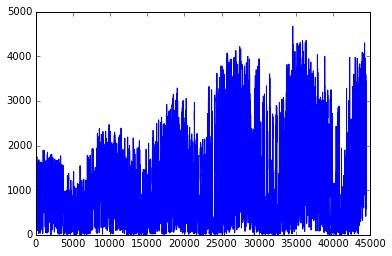

In [26]:
#Plot of all WindTotal data
lo = 0
hi = CAISO_Wind.WindTotal.shape[0]
plt.plot(range(lo,hi),list(CAISO_Wind.WindTotal[lo:hi]))

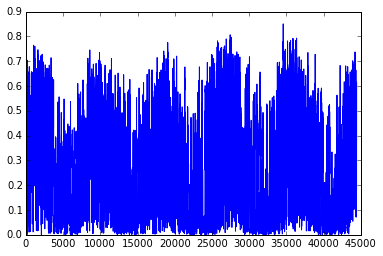

In [27]:
#Plot of all WindTotal data
lo = 0
hi = CAISO_Wind.WindTotal.shape[0]
plt.plot(range(lo,hi),list(CAISO_Wind.P_Cap[lo:hi]))

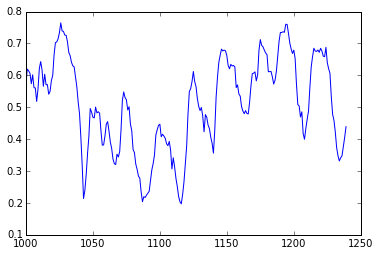

In [28]:
#Plot of all WindTotal data
lo = 1000
hi = 1240
plt.plot(range(lo,hi),list(CAISO_Wind.P_Cap[lo:hi]))

##Load NOAA Data

In [29]:
#Lists all the files in the data folder

file_list_CAMPO = glob.glob('data/NOAA_WeatherData/NOAA_files/CAMPO/*.html')
file_list_Livermore = glob.glob('data/NOAA_WeatherData/NOAA_files/LivermoreMuniApt/*.html')
file_list_PSIA = glob.glob('data/NOAA_WeatherData/NOAA_files/PalmSpringsIntlApt/*.html')
file_list_PortChicago = glob.glob('data/NOAA_WeatherData/NOAA_files/PortChicago/*.html')
file_list_Redding = glob.glob('data/NOAA_WeatherData/NOAA_files/ReddingMuniApt/*.html')
file_list_Tehachapi = glob.glob('data/NOAA_WeatherData/NOAA_files/TehachapiMunicipal/*.html')

In [30]:
#All file lists should have 62 elements.  One for each month 4/2010 - 5/2015 inclusive.

[len(file_list_CAMPO),
len(file_list_Livermore),
len(file_list_PSIA),
len(file_list_PortChicago),
len(file_list_Redding),
len(file_list_Tehachapi)]

[62, 62, 62, 62, 62, 62]

In [31]:
#Programatically load NOAA station observation data into pd.DataFrame with appropriately
#named columns.  These DataFrames will be concatinated later, so column names should be
#unique.

#file_list is a list of files to be loaded, NOAAStation is a str to be concatinated 
#with the column titles.  Returns a pd.DataFrame.

def loadNOAAData(file_list, NOAAStation):
    
    DataHolder = pd.DataFrame([])
    
    #Load HTML file into DataHolder
    for f in file_list:
        data_raw = pd.read_html(f)
        data_raw = pd.DataFrame(data_raw[1])
        data_raw.columns = data_raw.iloc[0,:]
        data_raw = data_raw.iloc[2:,:]
        data_raw = data_raw[['YR--MODAHRMN','DIR',
                        'SPD','GUS','TEMP','DEWP','SLP','STP']]
        DataHolder = pd.concat([DataHolder, data_raw], axis = 0)
    
    #Deal with NAN and non-sensical data entries
    DataHolder.SPD = DataHolder.SPD.replace('***',0) #numerical
    DataHolder.GUS = DataHolder.GUS.replace('***',0) #numerical
    DataHolder.DIR = DataHolder.DIR.replace(['***','990'],['No_Wind','DIR_Not_Reported']) #class
    DataHolder.STP = DataHolder.STP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.SLP = DataHolder.SLP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.TEMP = DataHolder.TEMP.replace('****', np.nan) #numerical
    DataHolder.DEWP = DataHolder.DEWP.replace('****', np.nan) #numerical
    
    #Change dtypes to those appropriate for modeling
    DataHolder['YR--MODAHRMN'] = DataHolder['YR--MODAHRMN'].astype(int)
    DataHolder.SPD = DataHolder.SPD.astype(int)
    DataHolder.GUS = DataHolder.GUS.astype(int)
    DataHolder.DIR = DataHolder.DIR.astype(str)
    DataHolder.STP = DataHolder.STP.astype(float)
    DataHolder.SLP = DataHolder.SLP.astype(float)
    DataHolder.TEMP = DataHolder.TEMP.astype(float)
    DataHolder.DEWP = DataHolder.DEWP.astype(float)
    
    #Rename columns to unique headdings
    DataHolder.columns = [NOAAStation + '_INDEX',NOAAStation + '_Wind_Dir',
                          NOAAStation + '_Wind_Spd',NOAAStation + '_Gust_Spd',
                          NOAAStation + '_Temp',NOAAStation + '_Dew_Pt',
                          NOAAStation + '_SLP',NOAAStation + '_StaP']
    
    DataHolder = DataHolder.dropna() #Drop all rows with any NA values
    
    #Round to the nearest hour, and then drop all instances for which there is more than one observation
    DataHolder[NOAAStation + '_INDEX'] = [np.round(x,-2)//100 for x in DataHolder[NOAAStation + '_INDEX']]
    DataHolder = DataHolder.drop_duplicates(subset = NOAAStation + '_INDEX')
    
    #Reindex the 
    DataHolder.index = DataHolder[NOAAStation + '_INDEX'].astype(int)

    print 'loadNOAAData(' + NOAAStation + ') Completed.'
    return DataHolder

In [32]:
#This function is nearly identical to the one above, but excludes Station Pressue and Dew Point data from the 
#loaded columns because these data were not reported for Port Chicago Station.  

def loadNOAAData_PortChicago(file_list, NOAAStation):
    
    DataHolder = pd.DataFrame([])
    
    #Load HTML file into DataHolder
    for f in file_list:
        data_raw = pd.read_html(f)
        data_raw = pd.DataFrame(data_raw[1])
        data_raw.columns = data_raw.iloc[0,:]
        data_raw = data_raw.iloc[2:,:]
        data_raw = data_raw[['YR--MODAHRMN','DIR',
                        'SPD','GUS','TEMP','SLP']]
        DataHolder = pd.concat([DataHolder, data_raw], axis = 0)
    
    #Deal with NAN and non-sensical data entries
    DataHolder.SPD = DataHolder.SPD.replace('***',0) #numerical
    DataHolder.GUS = DataHolder.GUS.replace('***',0) #numerical
    DataHolder.DIR = DataHolder.DIR.replace(['***','990'],['No_Wind','DIR_Not_Reported']) #class
    DataHolder.SLP = DataHolder.SLP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.TEMP = DataHolder.TEMP.replace('****', np.nan) #numerical
    
    DataHolder['YR--MODAHRMN'] = DataHolder['YR--MODAHRMN'].astype(int)
    DataHolder.SPD = DataHolder.SPD.astype(int)
    DataHolder.GUS = DataHolder.GUS.astype(int)
    DataHolder.DIR = DataHolder.DIR.astype(str)
    DataHolder.SLP = DataHolder.SLP.astype(float)
    DataHolder.TEMP = DataHolder.TEMP.astype(float)
    
    #Rename columns to unique headdings
    DataHolder.columns = [NOAAStation + '_INDEX',NOAAStation + '_Wind_Dir',
                          NOAAStation + '_Wind_Spd',NOAAStation + '_Gust_Spd',
                          NOAAStation + '_Temp',
                          NOAAStation + '_SLP']
    
    DataHolder = DataHolder.dropna() #Drop all rows with any NA values
    
    #Round to the nearest hour, and then drop all instances for which there is more than one observation
    DataHolder[NOAAStation + '_INDEX'] = [np.round(x,-2)//100 + 1 for x in DataHolder[NOAAStation + '_INDEX']]
    DataHolder = DataHolder.drop_duplicates(subset = NOAAStation + '_INDEX')
    
    #Reindex the 
    DataHolder.index = DataHolder[NOAAStation + '_INDEX'].astype(int)
    
    print 'loadNOAAData(' + NOAAStation + ') Completed.'
    return DataHolder

In [33]:
#This cell loads all NOAA station data, it takes a while to run. (~3min on my laptop)

Start = time.time()

NOAA_Data_CAMPO = loadNOAAData(file_list_CAMPO, 'CAMPO')
NOAA_Data_Livermore = loadNOAAData(file_list_Livermore, 'Livermore')
NOAA_Data_PSIA = loadNOAAData(file_list_PSIA, 'PSIA')
NOAA_Data_Redding = loadNOAAData(file_list_CAMPO, 'Redding')
NOAA_Data_Tehachapi = loadNOAAData(file_list_CAMPO, 'Tehachapi')

#Port Chicago treated seperately because Station Pressure and Dew Point were never reported
NOAA_Data_PortChicago = loadNOAAData_PortChicago(file_list_PortChicago, 'PortChicago')

print ""
print "COMPLETED LOADING ALL DATA"
print "Elapsed time = " + str(int(time.time()-Start)) + " seconds."

loadNOAAData(CAMPO) Completed.
loadNOAAData(Livermore) Completed.
loadNOAAData(PSIA) Completed.
loadNOAAData(Redding) Completed.
loadNOAAData(Tehachapi) Completed.
loadNOAAData(PortChicago) Completed.

COMPLETED LOADING ALL DATA
Elapsed time = 218 seconds.


In [34]:
pd.DataFrame([
        [NOAA_Data_CAMPO.shape[0] - NOAA_Data_CAMPO.index.unique().shape[0]], 
 [NOAA_Data_Livermore.shape[0] - NOAA_Data_Livermore.index.unique().shape[0]], 
 [NOAA_Data_PSIA.shape[0] - NOAA_Data_PSIA.index.unique().shape[0]],
 [NOAA_Data_PortChicago.shape[0] - NOAA_Data_PortChicago.index.unique().shape[0]],
 [NOAA_Data_Redding.shape[0] - NOAA_Data_Redding.index.unique().shape[0]],
 [NOAA_Data_Tehachapi.shape[0] - NOAA_Data_Tehachapi.index.unique().shape[0]]], 
             columns = ['Num_Non-Unique_Rows'], index = ['CAMPO','Livermore','PSIA','Redding','Tehachapi','PortChicago'])

,Num_Non-Unique_Rows
CAMPO,0
Livermore,0
PSIA,0
Redding,0
Tehachapi,0
PortChicago,0


In [35]:
DATA = pd.concat([NOAA_Data_CAMPO, NOAA_Data_Livermore, NOAA_Data_PSIA, 
                  NOAA_Data_PortChicago, NOAA_Data_Redding, NOAA_Data_Tehachapi, CAISO_Wind], axis = 1)

In [36]:
DATA = DATA.dropna()

In [37]:
DATA.shape

(43063, 54)

##Sinusoidal Year

In [40]:
Sun_lat = 35.0
Sun_long = -118.3

In [41]:
DATA.YEAR = DATA.YEAR.astype(int)
DATA.MONTH = DATA.MONTH.astype(int)
DATA.DAY = DATA.DAY.astype(int)
DATA.HOUR = DATA.HOUR.astype(int)

In [42]:
DATA = DATA.drop(range(2012022901,2012022925))

In [43]:
DATA['Max_Sun_Angle'] = np.nan
MSA = DATA.Max_Sun_Angle

In [48]:
for i in DATA.index:
    if DATA.HOUR.loc[i] == 1:
        SunAngle = []
        for hour in range(0,23):
            SunAngle.append(Pysolar.solar.GetAltitude(Sun_lat, Sun_long, datetime.datetime(DATA.YEAR[i], DATA.MONTH[i], 
                                                                                          DATA.DAY[i], hour, 0, 0, 0)))
    
        MSA[i] = max(SunAngle)

DATA.Max_Sun_Angle = MSA

/Users/pmeleney/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
#CAISO_Wind.Total_Capacity = CAISO_Wind.Total_Capacity.fillna(method = 'ffill')
DATA.Max_Sun_Angle = DATA.Max_Sun_Angle.fillna(method = 'ffill')

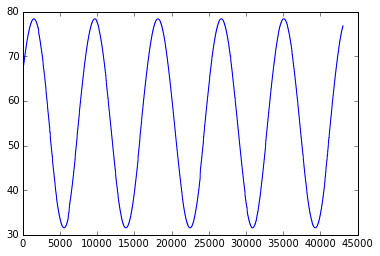

In [62]:
#Plot of all WindTotal data
lo = 0
hi = DATA.shape[0]
plt.plot(range(lo,hi),list(DATA.Max_Sun_Angle[lo:hi]))

In [64]:
DATA.sample(10)

,CAMPO_INDEX,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,Livermore_INDEX,Livermore_Wind_Dir,...,Tehachapi_StaP,INDEX,WindTotal,YEAR,MONTH,DAY,HOUR,Total_Capacity,P_Cap,Max_Sun_Angle
2011081701,2011081701,280,14,0,90,31,1009.9,921.0,2011081701,300,...,921.0,2011081701,1830,2011,8,17,1,3360.88,0.544500,68.326983
2015031107,2015031107,050,5,0,44,31,1015.5,925.1,2015031107,270,...,925.1,2015031107,422,2015,3,11,7,5829.53,0.072390,51.405317
2013121305,2013121305,050,7,0,34,24,1021.2,928.8,2013121305,No_Wind,...,928.8,2013121305,1125,2013,12,13,5,5491.33,0.204868,31.757574
2010061109,2010061109,No_Wind,0,0,47,45,1008.2,918.5,2010061109,180,...,918.5,2010061109,1251,2010,6,11,9,2479.58,0.504521,78.021152
2014012411,2014012411,060,16,24,59,13,1017.7,927.3,2014012411,No_Wind,...,927.3,2014012411,790,2014,1,24,11,5491.33,0.143863,35.932925
2012091602,2012091602,050,9,0,79,38,1013.7,924.4,2012091602,300,...,924.4,2012091602,1199,2012,9,16,2,4380.38,0.273721,57.131195
2012020710,2012020710,060,11,0,50,18,1011.8,921.6,2012020710,No_Wind,...,921.6,2012020710,325,2012,2,7,10,3811.58,0.085266,39.690237
2011071812,2011071812,050,3,0,50,36,1009.4,920.4,2011071812,No_Wind,...,920.4,2011071812,379,2011,7,18,12,3360.88,0.112768,75.975665
2010090217,2010090217,No_Wind,0,0,90,37,1009.4,921.0,2010090217,No_Wind,...,921.0,2010090217,22,2010,9,2,17,2479.58,0.008872,62.684752
2015041114,2015041114,030,3,0,36,33,1012.6,921.3,2015041114,No_Wind,...,921.3,2015041114,2359,2015,4,11,14,5829.53,0.404664,63.395747


In [71]:
IndexList = ['INDEX', 'CAMPO_INDEX', 'Livermore_INDEX', 'PSIA_INDEX', 'PortChicago_INDEX', 'Redding_INDEX', 'Tehachapi_INDEX']

for col in IndexList:
    if col in DATA.columns:
        DATA = DATA.drop(col, axis = 1)

In [72]:
DATA.head()

,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,Livermore_Wind_Dir,Livermore_Wind_Spd,Livermore_Gust_Spd,...,Tehachapi_SLP,Tehachapi_StaP,WindTotal,YEAR,MONTH,DAY,HOUR,Total_Capacity,P_Cap,Max_Sun_Angle
2010042001,260,10,0,67,49,1011.2,921.0,280,16,0,...,1011.2,921.0,632,2010,4,20,1,2479.58,0.254882,66.629337
2010042002,230,9,0,62,50,1011.7,921.3,270,10,0,...,1011.7,921.3,632,2010,4,20,2,2479.58,0.254882,66.629337
2010042003,No_Wind,0,0,57,50,1012.3,921.9,330,3,0,...,1012.3,921.9,677,2010,4,20,3,2479.58,0.273030,66.629337
2010042004,No_Wind,0,0,54,50,1012.6,922.3,No_Wind,0,0,...,1012.6,922.3,923,2010,4,20,4,2479.58,0.372240,66.629337
2010042005,No_Wind,0,0,51,49,1012.9,922.6,No_Wind,0,0,...,1012.9,922.6,875,2010,4,20,5,2479.58,0.352882,66.629337


In [73]:
DATA.columns

Index([u'CAMPO_Wind_Dir', u'CAMPO_Wind_Spd', u'CAMPO_Gust_Spd', u'CAMPO_Temp',
       u'CAMPO_Dew_Pt', u'CAMPO_SLP', u'CAMPO_StaP', u'Livermore_Wind_Dir',
       u'Livermore_Wind_Spd', u'Livermore_Gust_Spd', u'Livermore_Temp',
       u'Livermore_Dew_Pt', u'Livermore_SLP', u'Livermore_StaP',
       u'PSIA_Wind_Dir', u'PSIA_Wind_Spd', u'PSIA_Gust_Spd', u'PSIA_Temp',
       u'PSIA_Dew_Pt', u'PSIA_SLP', u'PSIA_StaP', u'PortChicago_Wind_Dir',
       u'PortChicago_Wind_Spd', u'PortChicago_Gust_Spd', u'PortChicago_Temp',
       u'PortChicago_SLP', u'Redding_Wind_Dir', u'Redding_Wind_Spd',
       u'Redding_Gust_Spd', u'Redding_Temp', u'Redding_Dew_Pt', u'Redding_SLP',
       u'Redding_StaP', u'Tehachapi_Wind_Dir', u'Tehachapi_Wind_Spd',
       u'Tehachapi_Gust_Spd', u'Tehachapi_Temp', u'Tehachapi_Dew_Pt',
       u'Tehachapi_SLP', u'Tehachapi_StaP', u'WindTotal', u'YEAR', u'MONTH',
       u'DAY', u'HOUR', u'Total_Capacity', u'P_Cap', u'Max_Sun_Angle'],
      dtype='object')

In [75]:
DATA.to_csv('Data.csv')